In [59]:
import time
import numpy as np
import pandas as pd
import pandas_profiling
import sweetviz
import dtale
import warnings, gc
from pycaret.classification import *
import seaborn as sns
import matplotlib.pyplot as plt

from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import TPESampler
import optuna
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("ACME-HappinessSurvey2020.csv")
df

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5
...,...,...,...,...,...,...,...
121,1,5,2,3,4,4,3
122,1,5,2,3,4,2,5
123,1,5,3,3,4,4,5
124,0,4,3,3,4,4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


There are 16 duplicate rows in the dataset, so we need to drop them because we do not want the model to overfit.

In [4]:
len(df)-len(df.drop_duplicates())

16

In [5]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)
df

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,1,5,5,3,5,5,5
...,...,...,...,...,...,...,...
105,0,4,4,4,4,1,3
106,1,5,2,3,4,4,3
107,1,5,2,3,4,2,5
108,0,4,3,3,4,4,5


Now we can have a look at the correlation matrix to see which faetures might be more relevant for predicting the target variable. Apperently, X2 has very insignificant correlation.

<AxesSubplot:>

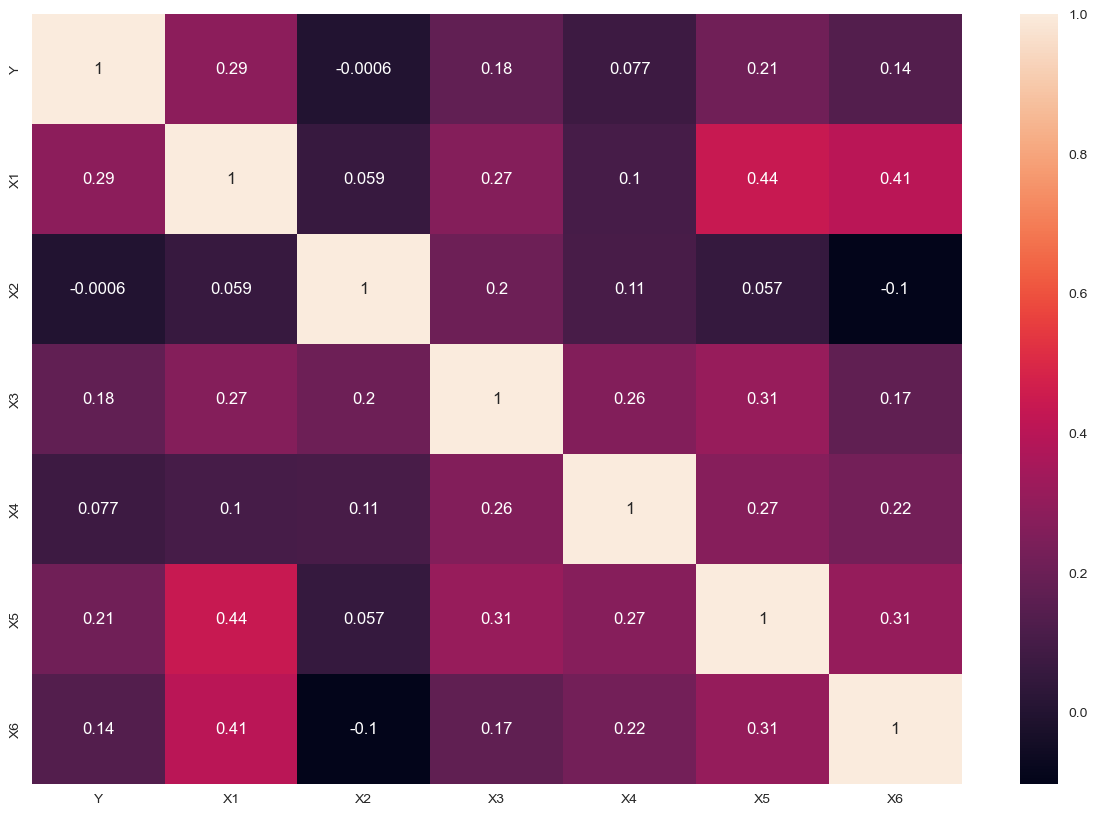

In [6]:
fig, ax = plt.subplots(figsize=(15,10))  
corr = df.corr()
sns.heatmap(corr, annot=True)

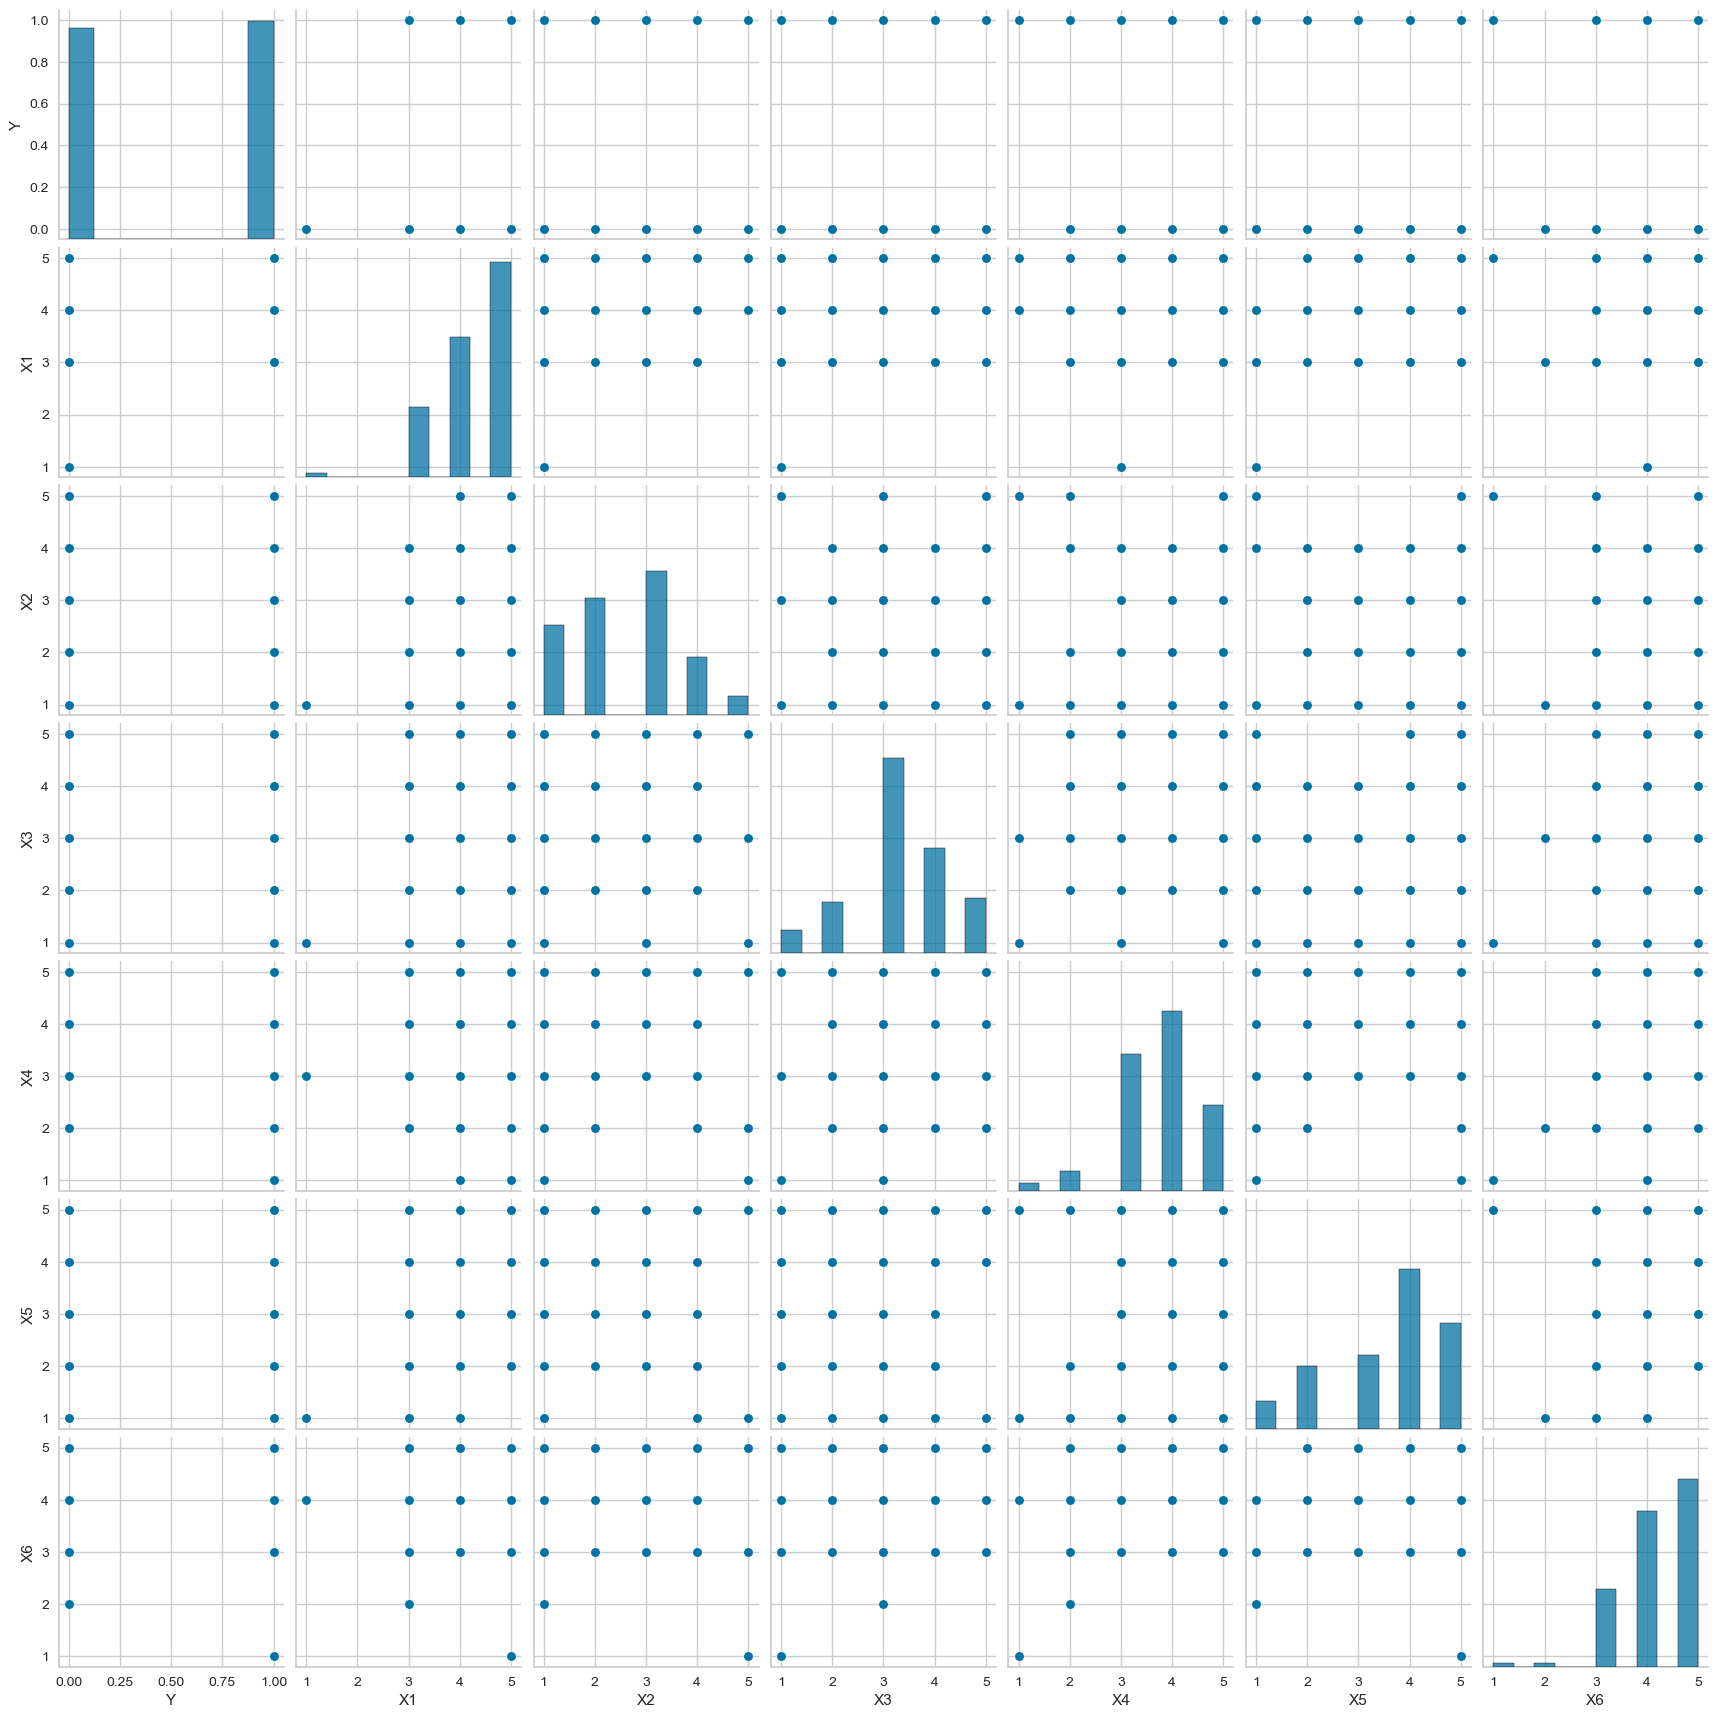

In [277]:
sns.pairplot(df)

In [241]:
y = df['Y']
X = df.drop(['Y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [278]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
lgbm = LGBMClassifier()

models = [knn, rf, dt, lgbm]

def test_models(l):
    
    for model in models:
        
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        acc = accuracy_score(y_test, y_predict)
        print(model)
        print("\nThe Training Accuracy is : {} \n".format(model.score(X_train,y_train)*100))
        print('The Test Accuracy is : {}\n\n'.format(acc) )
    
test_models(models)    

KNeighborsClassifier()

The Training Accuracy is : 63.63636363636363 

The Test Accuracy is : 0.5454545454545454


RandomForestClassifier()

The Training Accuracy is : 94.31818181818183 

The Test Accuracy is : 0.5


DecisionTreeClassifier()

The Training Accuracy is : 94.31818181818183 

The Test Accuracy is : 0.5


LGBMClassifier()

The Training Accuracy is : 68.18181818181817 

The Test Accuracy is : 0.7727272727272727




# Tune Models

## LGBM

In [243]:
def objective_lgbm(trial):
    """
    Objective function to be minimized.
    """
    
    param = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "objective": "binary",
        "metric": "accuracy",
        "verbosity": -1,
        "boosting_type": "dart",
        "n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12)
        
        
    }
    lgbm = LGBMClassifier(**param)
    lgbm.fit(X_train, y_train)
    preds = lgbm.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective_lgbm, n_trials=5)

best_params_lgbm = study.best_params
best_params_lgbm

[I 2023-03-27 07:13:44,102] A new study created in memory with name: lightgbm
[I 2023-03-27 07:13:44,145] Trial 0 finished with value: 0.7727272727272727 and parameters: {'n_estimators': 100, 'learning_rate': 0.21434078230426126, 'num_leaves': 2180, 'max_depth': 3}. Best is trial 0 with value: 0.7727272727272727.
[I 2023-03-27 07:13:44,175] Trial 1 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 100, 'learning_rate': 0.1581429605896015, 'num_leaves': 460, 'max_depth': 3}. Best is trial 0 with value: 0.7727272727272727.
[I 2023-03-27 07:13:44,214] Trial 2 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 100, 'learning_rate': 0.10126750357505873, 'num_leaves': 1040, 'max_depth': 6}. Best is trial 0 with value: 0.7727272727272727.
[I 2023-03-27 07:13:44,245] Trial 3 finished with value: 0.7727272727272727 and parameters: {'n_estimators': 100, 'learning_rate': 0.2740201996616449, 'num_leaves': 1260, 'max_depth': 9}. Best is trial 0 with valu

{'n_estimators': 100,
 'learning_rate': 0.21434078230426126,
 'num_leaves': 2180,
 'max_depth': 3}

In [244]:
lgbm = LGBMClassifier(**best_params_lgbm, boosting_type= "dart", metric= "accuracy")
lgbm.fit(X_train, y_train)

y_predict_model = lgbm.predict(X_test)
acc_model = accuracy_score(y_test, y_predict_model)
print("\nThe Training Score: {} \n".format(lgbm.score(X_train,y_train)*100))
print('The Accuracy is : {}\n\n'.format(acc_model) )


The Training Score: 68.18181818181817 

The Accuracy is : 0.7727272727272727




## KNN

In [245]:
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
def objective_knn(trial):
    """
    Objective function to be minimized.
    """
    
    param = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 30, step=1)        
        
    }
    knn = KNeighborsClassifier(**param)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="knn", direction="maximize", sampler=sampler)
study.optimize(objective_knn, n_trials=20)

best_params_knn = study.best_params
best_params_knn

[I 2023-03-27 07:13:51,946] A new study created in memory with name: knn
[I 2023-03-27 07:13:51,959] Trial 0 finished with value: 0.45454545454545453 and parameters: {'n_neighbors': 13}. Best is trial 0 with value: 0.45454545454545453.
[I 2023-03-27 07:13:51,966] Trial 1 finished with value: 0.5 and parameters: {'n_neighbors': 22}. Best is trial 1 with value: 0.5.
[I 2023-03-27 07:13:51,972] Trial 2 finished with value: 0.5454545454545454 and parameters: {'n_neighbors': 1}. Best is trial 2 with value: 0.5454545454545454.
[I 2023-03-27 07:13:51,978] Trial 3 finished with value: 0.45454545454545453 and parameters: {'n_neighbors': 10}. Best is trial 2 with value: 0.5454545454545454.
[I 2023-03-27 07:13:51,984] Trial 4 finished with value: 0.5454545454545454 and parameters: {'n_neighbors': 5}. Best is trial 2 with value: 0.5454545454545454.
[I 2023-03-27 07:13:51,989] Trial 5 finished with value: 0.6363636363636364 and parameters: {'n_neighbors': 3}. Best is trial 5 with value: 0.636363636

{'n_neighbors': 6}

In [246]:
knn = KNeighborsClassifier(**best_params_knn)
knn.fit(X_train, y_train)

y_predict_model = knn.predict(X_test)
acc_model = accuracy_score(y_test, y_predict_model)
print("\nThe Training Score: {} \n".format(knn.score(X_train,y_train)*100))
print('The Accuracy is : {}\n\n'.format(acc_model) )


The Training Score: 61.36363636363637 

The Accuracy is : 0.6818181818181818




## RF

In [247]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
def objective_rf(trial):
    """
    Objective function to be minimized.
    """
    
    param = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 20, 100, step=5),
        #"random_state": 17
        "random_state": trial.suggest_int("random_state", 17, 23, step=1),
        "criterion": trial.suggest_categorical("criterion", ['gini'])
        
        
    }
    rf = RandomForestClassifier(**param)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="rf", direction="maximize", sampler=sampler)
study.optimize(objective_rf, n_trials=50)

best_params_rf = study.best_params
best_params_rf

[I 2023-03-27 07:13:55,485] A new study created in memory with name: rf
[I 2023-03-27 07:13:55,566] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 55, 'random_state': 22, 'criterion': 'gini'}. Best is trial 0 with value: 0.5.
[I 2023-03-27 07:13:55,594] Trial 1 finished with value: 0.4090909090909091 and parameters: {'n_estimators': 20, 'random_state': 19, 'criterion': 'gini'}. Best is trial 0 with value: 0.5.
[I 2023-03-27 07:13:55,633] Trial 2 finished with value: 0.5909090909090909 and parameters: {'n_estimators': 30, 'random_state': 17, 'criterion': 'gini'}. Best is trial 2 with value: 0.5909090909090909.
[I 2023-03-27 07:13:55,677] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 35, 'random_state': 19, 'criterion': 'gini'}. Best is trial 2 with value: 0.5909090909090909.
[I 2023-03-27 07:13:55,738] Trial 4 finished with value: 0.45454545454545453 and parameters: {'n_estimators': 50, 'random_state': 20, 'criterion': 'gini'}. Best is trial 2 with

[I 2023-03-27 07:13:57,749] Trial 38 finished with value: 0.6818181818181818 and parameters: {'n_estimators': 25, 'random_state': 17, 'criterion': 'gini'}. Best is trial 15 with value: 0.6818181818181818.
[I 2023-03-27 07:13:57,791] Trial 39 finished with value: 0.5 and parameters: {'n_estimators': 20, 'random_state': 21, 'criterion': 'gini'}. Best is trial 15 with value: 0.6818181818181818.
[I 2023-03-27 07:13:57,869] Trial 40 finished with value: 0.5909090909090909 and parameters: {'n_estimators': 50, 'random_state': 19, 'criterion': 'gini'}. Best is trial 15 with value: 0.6818181818181818.
[I 2023-03-27 07:13:57,920] Trial 41 finished with value: 0.6818181818181818 and parameters: {'n_estimators': 25, 'random_state': 17, 'criterion': 'gini'}. Best is trial 15 with value: 0.6818181818181818.
[I 2023-03-27 07:13:57,981] Trial 42 finished with value: 0.5454545454545454 and parameters: {'n_estimators': 35, 'random_state': 17, 'criterion': 'gini'}. Best is trial 15 with value: 0.68181818

{'n_estimators': 25, 'random_state': 17, 'criterion': 'gini'}

In [248]:
rf = RandomForestClassifier(**best_params_rf)
rf.fit(X_train, y_train)

y_predict_model = rf.predict(X_test)
acc_model = accuracy_score(y_test, y_predict_model)
print("\nThe Training Score: {} \n".format(rf.score(X_train,y_train)*100))
print('The Accuracy is : {}\n\n'.format(acc_model) )


The Training Score: 93.18181818181817 

The Accuracy is : 0.6818181818181818




## DT

In [249]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
def objective_dt(trial):
    """
    Objective function to be minimized.
    """
    
    param = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20, step=1),
        #"random_state": 17
        "random_state": trial.suggest_int("random_state", 17, 23, step=1),
        "criterion": trial.suggest_categorical("criterion", ['gini'])
        
        
    }
    dt = DecisionTreeClassifier(**param)
    dt.fit(X_train, y_train)
    preds = dt.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="dt", direction="maximize", sampler=sampler)
study.optimize(objective_dt, n_trials=30)

best_params_dt = study.best_params
best_params_dt

[I 2023-03-27 07:13:58,949] A new study created in memory with name: dt
[I 2023-03-27 07:13:58,962] Trial 0 finished with value: 0.5454545454545454 and parameters: {'min_samples_split': 9, 'random_state': 22, 'criterion': 'gini'}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-27 07:13:58,968] Trial 1 finished with value: 0.5454545454545454 and parameters: {'min_samples_split': 2, 'random_state': 19, 'criterion': 'gini'}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-27 07:13:58,973] Trial 2 finished with value: 0.5 and parameters: {'min_samples_split': 4, 'random_state': 17, 'criterion': 'gini'}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-27 07:13:58,979] Trial 3 finished with value: 0.5 and parameters: {'min_samples_split': 5, 'random_state': 19, 'criterion': 'gini'}. Best is trial 0 with value: 0.5454545454545454.
[I 2023-03-27 07:13:58,983] Trial 4 finished with value: 0.5454545454545454 and parameters: {'min_samples_split': 9, 'random_state

{'min_samples_split': 18, 'random_state': 23, 'criterion': 'gini'}

In [250]:
dt = DecisionTreeClassifier(**best_params_dt)
dt.fit(X_train, y_train)

y_predict_model = dt.predict(X_test)
acc_model = accuracy_score(y_test, y_predict_model)
print("\nThe Training Score: {} \n".format(dt.score(X_train,y_train)*100))
print('The Accuracy is : {}\n\n'.format(acc_model) )


The Training Score: 71.5909090909091 

The Accuracy is : 0.6818181818181818




# Cross-validation

In [251]:
def train_model(model, fold_no, rs):
    
    skf = StratifiedKFold(n_splits=fold_no, shuffle=True, random_state=rs)#26
    lst_accu_stratified = []
    
    for train_index, test_index in skf.split(X_train, y_train):
        x_train_fold, x_test_fold = X.loc[train_index], X.loc[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        model.fit(x_train_fold, y_train_fold)
        lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))
    
    print('Model:', model)
    print('\nList of possible accuracy:', lst_accu_stratified)
    print('\nMaximum Accuracy That can be obtained from this model is:',
          max(lst_accu_stratified)*100, '%')
    print('\nMinimum Accuracy:',
          min(lst_accu_stratified)*100, '%')
    print('\nOverall Accuracy:',
          mean(lst_accu_stratified)*100, '%')
    print('\nStandard Deviation is:', stdev(lst_accu_stratified))

In [252]:
lgbm = LGBMClassifier(**best_params_lgbm, boosting_type= "dart", metric= "accuracy")
train_model(lgbm, 10, 35)

Model: LGBMClassifier(boosting_type='dart', learning_rate=0.21434078230426126,
               max_depth=3, metric='accuracy', num_leaves=2180)

List of possible accuracy: [0.7777777777777778, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.4444444444444444, 0.5555555555555556, 0.7777777777777778, 0.8888888888888888, 0.625, 0.375]

Maximum Accuracy That can be obtained from this model is: 88.88888888888889 %

Minimum Accuracy: 37.5 %

Overall Accuracy: 61.111111111111114 %

Standard Deviation is: 0.1594368088678015


In [253]:
lgbm

LGBMClassifier(boosting_type='dart', learning_rate=0.21434078230426126,
               max_depth=3, metric='accuracy', num_leaves=2180)

In [254]:
y_predict_model = lgbm.predict(X_test)
acc_model = accuracy_score(y_test, y_predict_model)
print('The Accuracy is : {}\n\n'.format(acc_model) )

The Accuracy is : 0.8636363636363636




In [158]:
train_model(knn, 10, 35)

Model: KNeighborsClassifier(n_neighbors=6)

List of possible accuracy: [0.6666666666666666, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.6666666666666666, 0.5555555555555556, 0.4444444444444444, 0.7777777777777778, 0.5, 0.625]

Maximum Accuracy That can be obtained from this model is: 77.77777777777779 %

Minimum Accuracy: 44.44444444444444 %

Overall Accuracy: 55.69444444444444 %

Standard Deviation is: 0.12080583623561864


In [159]:
y_predict_model = knn.predict(X_test)
acc_model = accuracy_score(y_test, y_predict_model)
print('The Accuracy is : {}\n\n'.format(acc_model) )

The Accuracy is : 0.8181818181818182




In [160]:
train_model(rf, 10, 35)

Model: RandomForestClassifier(n_estimators=25, random_state=17)

List of possible accuracy: [0.4444444444444444, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.7777777777777778, 0.7777777777777778, 0.4444444444444444, 0.5555555555555556, 0.75, 0.375]

Maximum Accuracy That can be obtained from this model is: 77.77777777777779 %

Minimum Accuracy: 33.33333333333333 %

Overall Accuracy: 54.58333333333333 %

Standard Deviation is: 0.18379687937215097


In [161]:
y_predict_model = rf.predict(X_test)
acc_model = accuracy_score(y_test, y_predict_model)
print('The Accuracy is : {}\n\n'.format(acc_model) )

The Accuracy is : 0.9090909090909091




In [162]:
train_model(dt, 10, 35)

Model: DecisionTreeClassifier(min_samples_split=18, random_state=23)

List of possible accuracy: [0.6666666666666666, 0.5555555555555556, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.5, 0.625]

Maximum Accuracy That can be obtained from this model is: 66.66666666666666 %

Minimum Accuracy: 33.33333333333333 %

Overall Accuracy: 56.80555555555556 %

Standard Deviation is: 0.11424027394944347


In [163]:
y_predict_model = dt.predict(X_test)
acc_model = accuracy_score(y_test, y_predict_model)
print('The Accuracy is : {}\n\n'.format(acc_model) )

The Accuracy is : 0.8181818181818182




Every model reached a test accuracy above 73%, and the best one was Random Forest

# Feature Importance

We can see below the feature importance for each model.

The most important features for Random classifier are X2 (contents of my order was as I expected) and X5 (I am satisfied with my courier), and the least one is X1 (my order was delivered on time).

For Decision Tree X1 and X6 (the app makes ordering easy for me) are the most relevant ones, with X2 being the most irrelevant.

Finally, the important features for LGBM are X1 and X2, and the least important is X6.

X2 was an important feature for 2 models eventhough it has correlation with the target variable near zero, because correlation measures the strength of a linear relationship, but the relationship between X2 and the outcome may not be linear.

In [276]:
rf[-1].feature_importances_

array([0.15015688, 0.19099363, 0.14160685, 0.19075756, 0.10671439,
       0.21977069])

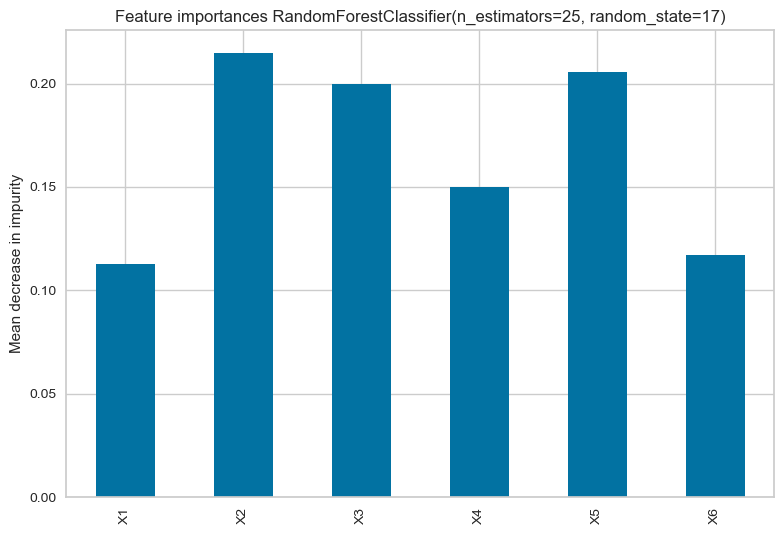

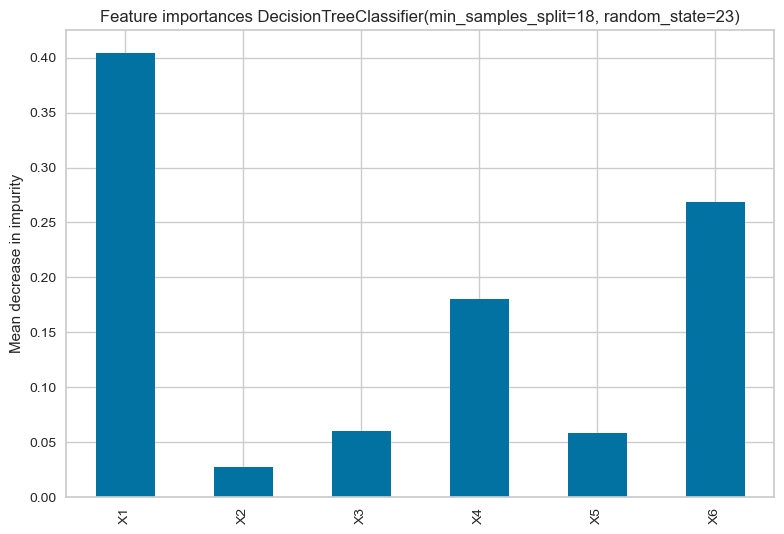

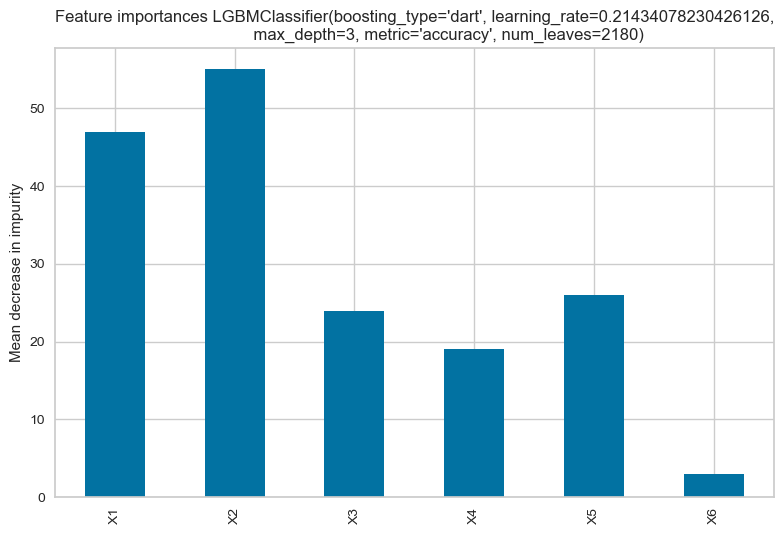

In [268]:
#https://stats.stackexchange.com/questions/519306/why-important-features-does-not-correlated-with-target-variable
feature_names = [f"X{i}" for i in range(1,X.shape[1]+1)]

models = [rf, dt, lgbm]

for model in models:
    

    importances = model.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
    
    #print("\n")
    #print(model)
    #print("\n")

    model_importances = pd.Series(importances, index=feature_names)

    # summarize feature importance
    #for i,v in enumerate(importance):
     #   print('Feature: %s, Score: %.5f' % (feature_names[i],v))

    fig, ax = plt.subplots()
    model_importances.plot.bar(ax=ax) #yerr=std, 
    ax.set_title("Feature importances %s" % model)
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()